In [4]:
import numpy as np
import pandas as pd
from spec_id import Scale_model,Gen_spec
import matplotlib.pyplot as plt
import grizli
from glob import glob
from scipy.interpolate import interp1d
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)
pandas2ri.activate()

In [2]:
galDB = pd.read_pickle('../chidat/BF_fullfit.pkl')
metal=np.round(np.arange(0.002,0.031,0.001),3)
age=np.round(np.arange(.5,6.1,.1),1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [3]:
rzoo = importr('zoo')

In [9]:
class Gen_spec(object):
    def __init__(self, galaxy_id, redshift,minwv = 8000, maxwv = 11200, shift = 1):
        self.galaxy_id = galaxy_id
        self.gid = int(self.galaxy_id[1:])
        self.redshift = redshift
        self.shift = shift

        """ 
        self.flt_input - grism flt (not image flt) which contains the object you're interested in modeling, this
                         will tell Grizli the PA
        **
        self.galaxy_id - used to id galaxy and import spectra
        **
        self.beam - information used to make models
        **
        self.wv - output wavelength array of simulated spectra
        **
        self.fl - output flux array of simulated spectra
        """

        gal_wv, gal_fl, gal_er = np.load(glob('../spec_stacks/*{0}*'.format(self.gid))[0])
        self.flt_input = glob('../beams/*{0}*'.format(self.gid))[0]

        IDX = [U for U in range(len(gal_wv)) if minwv <= gal_wv[U] <= maxwv]

        self.gal_wv_rf = gal_wv[IDX] / (1 + self.redshift)
        self.gal_wv = gal_wv[IDX]
        self.gal_fl = gal_fl[IDX]
        self.gal_er = gal_er[IDX]

        self.gal_wv_rf = self.gal_wv_rf[self.gal_fl > 0 ]
        self.gal_wv = self.gal_wv[self.gal_fl > 0 ]
        self.gal_er = self.gal_er[self.gal_fl > 0 ]
        self.gal_fl = self.gal_fl[self.gal_fl > 0 ]

#         WV,TEF = np.load('../data/template_error_function.npy')
#         iTEF = interp1d(WV,TEF)(self.gal_wv_rf)
#         self.gal_er = np.sqrt(self.gal_er**2 + (iTEF*self.gal_fl)**2)

        ## Spectrum cutouts
        self.beam = grizli.model.BeamCutout(fits_file=self.flt_input)

        ## Get sensitivity function

        flat = self.beam.flat_flam.reshape(self.beam.beam.sh_beam)
        fwv, ffl, e = self.beam.beam.optimal_extract(np.append(np.zeros([self.shift,flat.shape[0]]),flat.T[:-1],axis=0).T , bin=0)
        
        self.filt = interp1d(fwv, ffl)(self.gal_wv)
        
    def Sim_spec(self, metal, age, tau, model_redshift = 0, dust = 0):
        if model_redshift ==0:
            model_redshift = self.redshift
            
        model = '../../../fsps_models_for_fit/fsps_spec/m{0}_a{1}_dt{2}_spec.npy'.format(metal, age, tau)

        wave, fl = np.load(model)

        cal = 1
        if dust !=0:
            lam = wave * 1E-4
            Rv = 4.05
            k = 2.659*(-2.156 +1.509/(lam) -0.198/(lam**2) +0.011/(lam**3)) + Rv
            cal = 10**(-0.4 * k * dust / Rv)  
        
        ## Compute the models
        self.beam.compute_model(spectrum_1d=[wave*(1+model_redshift),fl * cal])

        ## Extractions the model (error array here is meaningless)
        w, f, e = self.beam.beam.optimal_extract(np.append(np.zeros([self.shift,self.beam.model.shape[0]]),
                                                           self.beam.model.T[:-1],axis=0).T , bin=0)

        ifl = interp1d(w, f)(self.gal_wv)
        adj_ifl = ifl /self.filt
        
        C = Scale_model(self.gal_fl, self.gal_er, adj_ifl)

        self.fl = C * adj_ifl

In [30]:
waves = np.array([])
flux = np.array([])
error = np.array([])
mflux = np.array([])

for i in galDB.index:
    sp = Gen_spec(galDB['gids'][i],galDB['bfz'][i],minwv=7900,maxwv=11200)
    if galDB.bftau[i] == 0:
        sp.Sim_spec(galDB.bfZ[i], galDB.bft[i],0,galDB.bfz[i],galDB.bfd[i])
    else:
        sp.Sim_spec(galDB.bfZ[i], galDB.bft[i],galDB.bftau[i],galDB.bfz[i],galDB.bfd[i])
    waves = np.append(waves,sp.gal_wv_rf[sp.gal_fl > 5E-19])
    flux = np.append(flux,sp.gal_fl[sp.gal_fl > 5E-19])
    error = np.append(error,sp.gal_er[sp.gal_fl > 5E-19])
    mflux = np.append(mflux,sp.fl[sp.gal_fl > 5E-19])

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: divide by zero encountered in true_divide
  self.op

In [31]:
IDW =waves.argsort()

In [32]:
df = pd.DataFrame({'wv':waves[IDW],'res':(flux[IDW] - mflux[IDW])/flux[IDW]})

In [33]:
eres = rzoo.zoo(df['res'][IDW],df['wv'][IDW])
rmeanl = rzoo.rollapply(eres,100,'mean', fill = 'NA', align ='left')
rstdl = rzoo.rollapply(eres,100,'sd', fill = 'NA', align ='left')
rmeanr = rzoo.rollapply(eres,100,'mean', fill = 'NA', align ='right')
rstdr = rzoo.rollapply(eres,100,'sd', fill = 'NA', align ='right')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in add
  import sys
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in subtract
  
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in add
  if __name__ == '__main__':
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in subtract
  # Remove the CWD from sys.path while we load stuff.


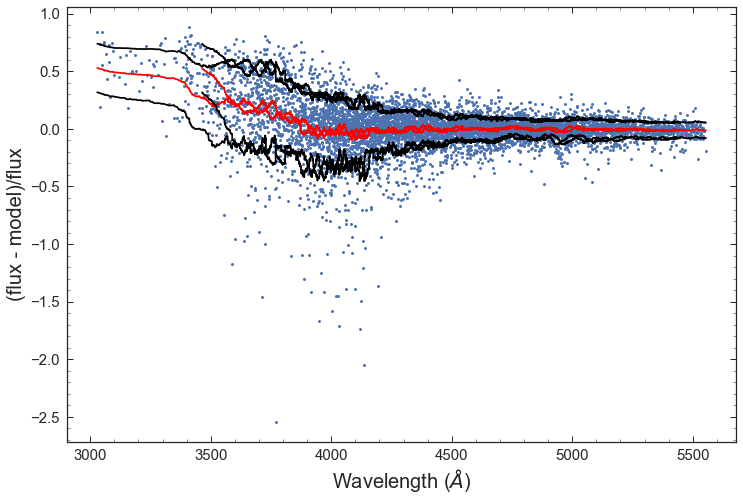

In [34]:
%matplotlib inline

plt.figure(figsize=[12,8])
plt.plot(waves[IDW],(flux[IDW] - mflux[IDW])/flux[IDW],'o',ms=3)
plt.plot(waves[IDW],rmeanl,'r',ms=2)
plt.plot(waves[IDW],rmeanr,'r',ms=2)
plt.plot(waves[IDW],np.array(rstdl) + np.array(rmeanl),'k')
plt.plot(waves[IDW],np.array(rmeanl) - np.array(rstdl),'k')
plt.plot(waves[IDW],np.array(rstdr) + np.array(rmeanr),'k')
plt.plot(waves[IDW],np.array(rmeanr) - np.array(rstdr),'k')
plt.xlabel('Wavelength ($\AA$)',fontsize = 20)
plt.ylabel('(flux - model)/flux',fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=15)
# plt.ylim(-5,5)

No handles with labels found to put in legend.


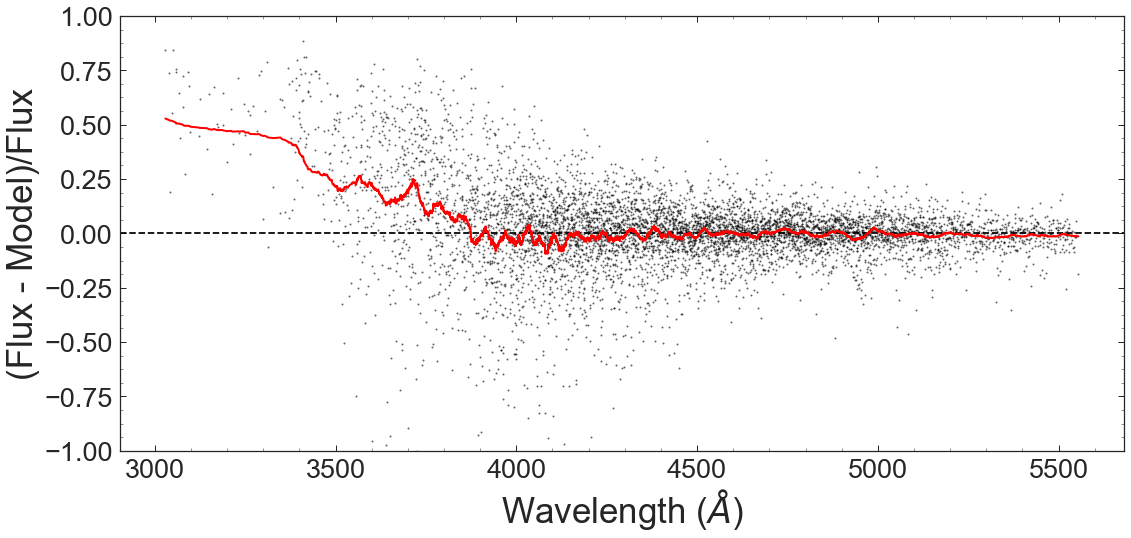

In [44]:
plt.figure(figsize=[18,8])
plt.axhline(0,color='k', linestyle ='--')
plt.plot(waves[IDW],(flux[IDW] - mflux[IDW])/flux[IDW],'ko',ms=2, alpha=.6)
plt.plot(waves[IDW],newrmean2,'r',ms=2, linewidth =2)
# plt.plot(waves[IDW],np.array(newrstd2) + np.array(newrmean2),'k')
# plt.plot(waves[IDW],np.array(newrmean2) - np.array(newrstd2),'k')
# plt.plot(waves[IDW],np.array(rstdr) + np.array(rmeanr),'k')
# plt.plot(waves[IDW],np.array(rmeanr) - np.array(rstdr),'k')
plt.xlabel('Wavelength ($\AA$)',fontsize = 35)
plt.ylabel('(Flux - Model)/Flux',fontsize = 35)
plt.tick_params(axis='both', which='major', labelsize=27)
# plt.ylim(-4,4)
# plt.axvline(3934.777,linestyle='--', alpha=.3)
# plt.axvline(3969.588,linestyle='--', alpha=.3)
# plt.axvline(4102.89,linestyle='--', alpha=.3)
# plt.axvline(4305.61,linestyle='--', alpha=.3)
# plt.axvline(4341.68,linestyle='--', alpha=.3)
# plt.axvline(4862.68,linestyle='--', alpha=.3)
# plt.axvline(5176.7,linestyle='--', alpha=.3)
# plt.axvspan(3910, 3980, color='k', alpha=.1)
# plt.axvspan(3980, 4030, color='k', alpha=.1)
# plt.axvspan(4080, 4120, color='k', alpha=.1)
# plt.axvspan(4250, 4380, color='k', alpha=.1)
# plt.axvspan(4810, 4910, color='k', alpha=.1)
# plt.axvspan(5120, 5240, color='k', alpha=.1)
# plt.text(3850,1.1,'Ca HK',fontsize=20)
# plt.text(4080,1.1,'H$\delta$',fontsize=20)
# plt.text(4250,1.1,'G+H$\gamma$',fontsize=20)
# plt.text(4830,1.1,'H$\\beta$',fontsize=20)
# plt.text(5160,1.1,'Mgb',fontsize=20)
plt.legend(fontsize = 15)
plt.ylim(-1,1)
plt.savefig('../plots/temp_err_func.pdf',bbox_inches = 'tight')

# plt.figure(figsize=[12,8])
# sea.distplot((flux[IDW] - mflux[IDW])/flux[IDW])
# plt.axvline(np.mean((flux[IDW] - mflux[IDW])/flux[IDW]),color='k',linestyle='--' )
# plt.axvline(np.std((flux[IDW] - mflux[IDW])/flux[IDW]),color='k',linestyle='-.' )
# plt.axvline(-np.std((flux[IDW] - mflux[IDW])/flux[IDW]),color='k',linestyle='-.')
# plt.ylabel('P',fontsize = 0)
# plt.xlabel('(Flux - Fodel)/Flux',fontsize = 30)
# # plt.ylim(-0.5,0.5)
# plt.tick_params(axis='both', which='major', labelsize=23)
# plt.legend(fontsize = 15)
# plt.savefig('../plots/temp_err_func.pdf',bbox_inches = 'tight')

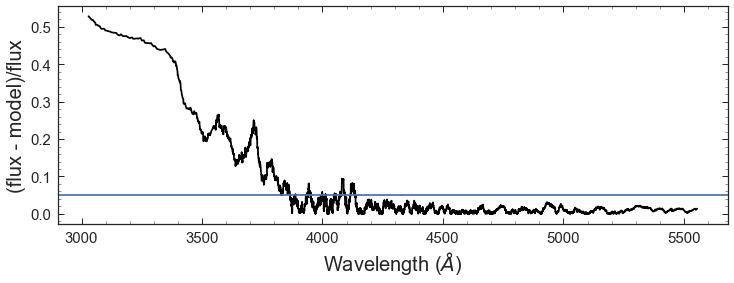

In [36]:
plt.figure(figsize=[12,4])
# plt.plot(waves[IDW],np.abs(rmeanl),'r',ms=2)
# plt.plot(waves[IDW],np.abs(rmeanr),'r',ms=2)
plt.plot(waves[IDW],newrmean,'k',ms=2)
plt.xlabel('Wavelength ($\AA$)',fontsize = 20)
plt.ylabel('(flux - model)/flux',fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.axhline(0.05)

In [35]:
newrmean = np.zeros(len(IDW))
for i in range(len(IDW)):
    if np.abs(rmeanl[i]) > 0:
        newrmean[i]=np.abs(rmeanl[i])
    else:
        newrmean[i]=np.abs(rmeanr[i])

newrmean2 = np.zeros(len(IDW))
for i in range(len(IDW)):
    if np.abs(rmeanl[i]) > 0:
        newrmean2[i]=rmeanl[i]
    else:
        newrmean2[i]=rmeanr[i]
        
newrstd2 = np.zeros(len(IDW))
for i in range(len(IDW)):
    if np.abs(rmeanl[i]) > 0:
        newrstd2[i]=rstdl[i]
    else:
        newrstd2[i]=rstdr[i]

In [36]:
np.save('../data/template_error_function',[waves[IDW],newrmean])